<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/normalisation-and-feature-selection/assignment_ecg_normalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

# Introduction

The objective of this notebook is to predict if a ECG recording is normal or abnormal. The features are acquired from Fourier analysis.

This notebook covers the following components:
*   **Data description and visualization**: data exploration to get acquainted with the data structure.
*   **Preprocessing**: this section consists of scaling, outliers, etc.
*   **Feature selection and extraction**: methods to select features such as Greed feature selection and extract features such as PCA will be applied.
*   **Classifier**: the apprioriate classifier will be selected based on theoretical knowledge or experiments.
*   **Experimental and evaluation setup**: evaluation of the ECG dataset on the model.







# Data description and visualization

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

Cloning into 'Group16_ECG'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 65 (delta 32), reused 12 (delta 2), pack-reused 3
Receiving objects: 100% (65/65), 65.27 MiB | 31.72 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
# data exploration
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 827
The number of columns: 9001


In [4]:
print('Number of unique values: \n',data.nunique().value_counts())
print('\n')
print('Number of datatypes present: \n',data.dtypes.value_counts())


Number of unique values: 
 827    6000
826    1500
824    1500
2         1
dtype: int64


Number of datatypes present: 
 float64    9000
int64         1
dtype: int64


There is a difference in unique numbers for different features. In the folllowing code we will look for explanations for these discongruity.

The dataset contains 9000 columns with floating variables: the outcomes of the fourrier analysis and one column with integers: the label (0 or 1). No categorical variables are present in the data.

In [5]:
data[data['10_90'].duplicated()]['10_90']

542    0.0
601    0.0
790    0.0
Name: 10_90, dtype: float64

In [6]:
print('zeros in 826 \n',data[data['7_0'].duplicated()]['7_0'])
print('zeros in 826 \n',data[data['8_0'].duplicated()]['8_0'])
print('zeros in 824 \n',data[data['10_0'].duplicated()]['10_0'])
print('zeros in 824 \n',data[data['11_0'].duplicated()]['11_0'])


zeros in 826 
 784    0.0
Name: 7_0, dtype: float64
zeros in 826 
 537    0.0
Name: 8_0, dtype: float64
zeros in 824 
 542    0.0
601    0.0
790    0.0
Name: 10_0, dtype: float64
zeros in 824 
 385    0.0
434    0.0
446    0.0
Name: 11_0, dtype: float64


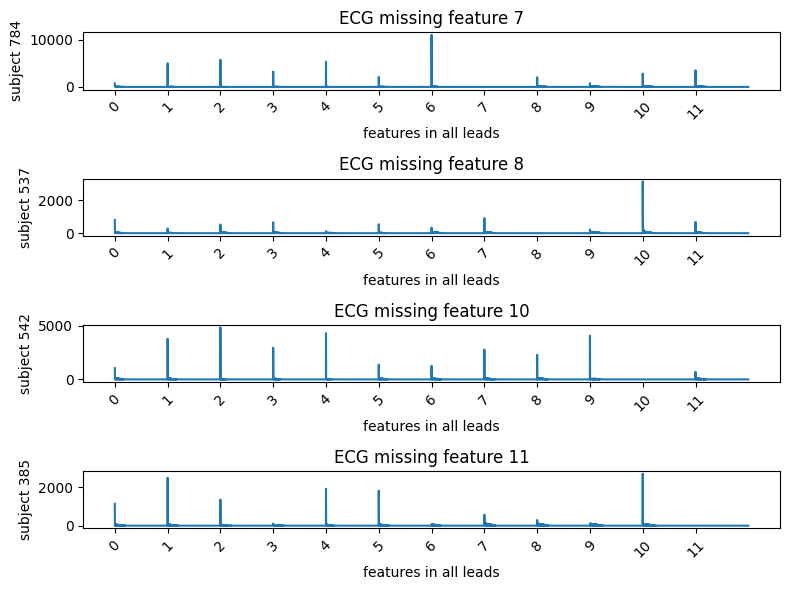

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 11')

plt.tight_layout()

plt.show()


This figure shows that for a few persons (n = 8), no recordings are available for one specific lead. This causes a lack of features for these persons.

In total there are 12 leads (0-11) and each lead has 750 features. The features in the columns are written as 0_20 with 0 the lead number and 20 the corresponding feature.



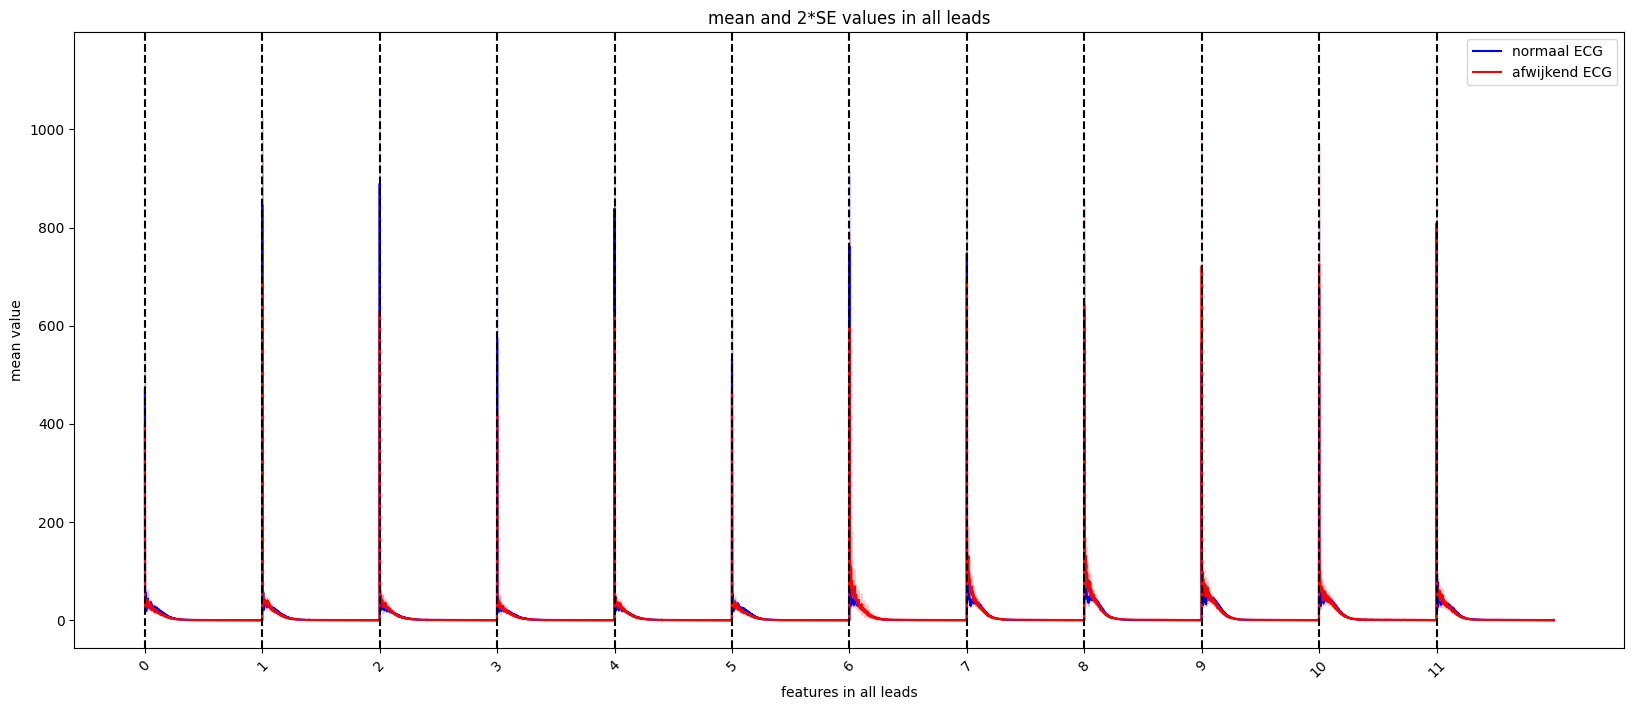

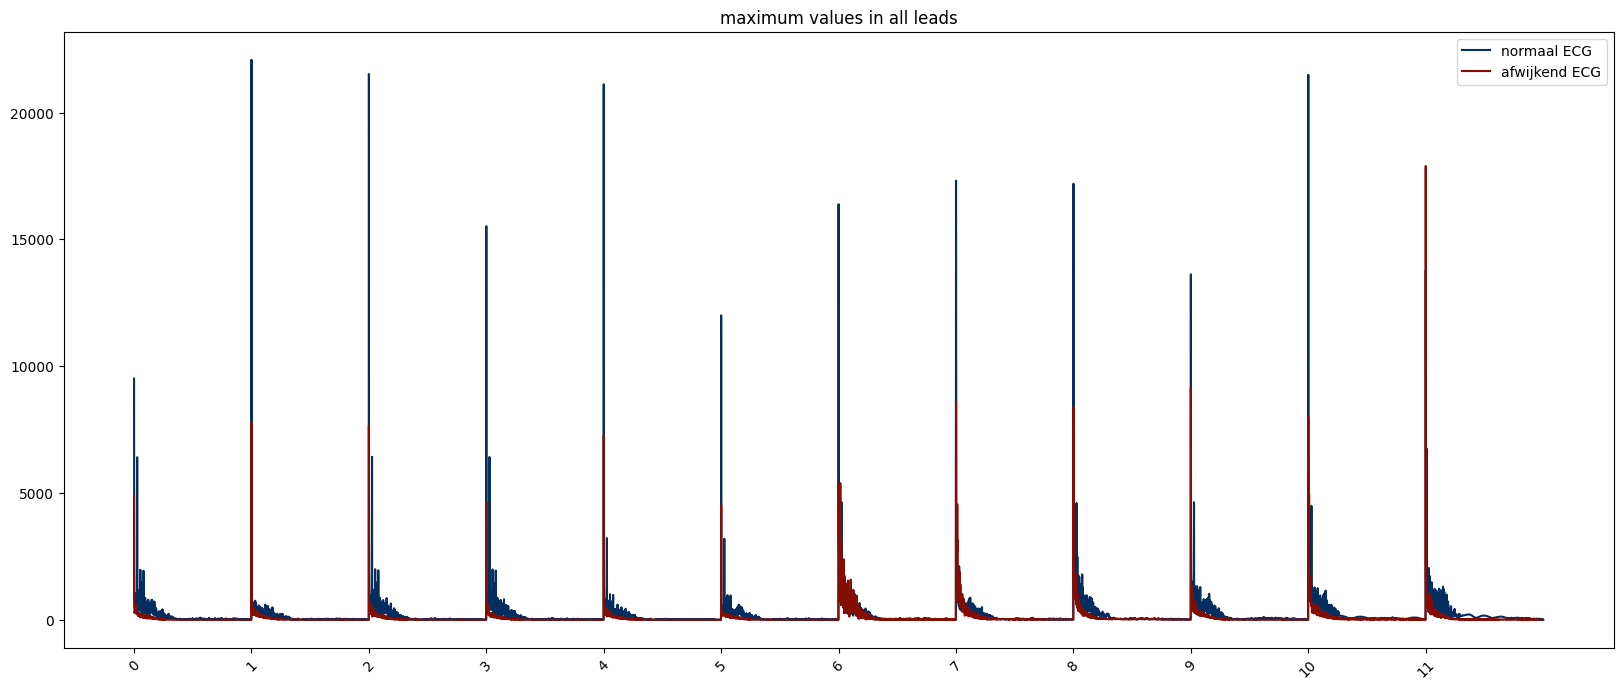

In [8]:
data_mean_0 = data[data['label']==0].mean()
data_mean_1 = data[data['label']==1].mean()

upperbound_0 = data_mean_0 + 2 * data[data['label']==0].sem()
lowerbound_0 = data_mean_0 - 2 * data[data['label']==0].sem()

upperbound_1 = data_mean_1 + 2 * data[data['label']==1].sem()
lowerbound_1 = data_mean_1 - 2 * data[data['label']==1].sem()

data_max_0 = data[data['label'] == 0].max()
data_max_1 = data[data['label'] == 1].max()


# figure with mean values
plt.figure(figsize=[20,8])
plt.plot(data.columns,data_mean_0,color = 'b')
plt.plot(data.columns,data_mean_1,color = 'r')
plt.fill_between(data.columns,lowerbound_0,upperbound_0,alpha = 0.2, color = 'b')
plt.fill_between(data.columns,lowerbound_1,upperbound_1,alpha = 0.2, color = 'r')

for v_line in np.arange(0,9000,750):
  plt.axvline(v_line,ymin = 0,color = 'k',linestyle = '--')

plt.legend(['normaal ECG','afwijkend ECG'])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('features in all leads')
plt.ylabel('mean value')
plt.title('mean and 2*SE values in all leads')

plt.show()

# figure with max values
plt.figure(figsize= [20,8])
plt.plot(data.columns,data_max_0,color = '#042e60')
plt.plot(data.columns,data_max_1,color = '#850e04')

plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.legend(['normaal ECG','afwijkend ECG'])
plt.title('maximum values in all leads')

plt.show()


Based on this figure: we decided to look deeper to the first 200 features for every lead because this area is easier to visualize. This doesn't mean that there is no useful information in the other feature but because of the scaling the feature further in the lead are smaller in the visualization.

Beside this you can see that for every lead in the beginning features reach high values. Because these values are consistently high we assume that these values aren't errors but contain usefull information. Therefore, we decided to keep the perceived outliers. These outliers go up to 1000. If values in a magnitude of millions were perceived, outliers handling would be appropriate. As no background is known about the features it is hard to estimate if outliers are errors or useful information

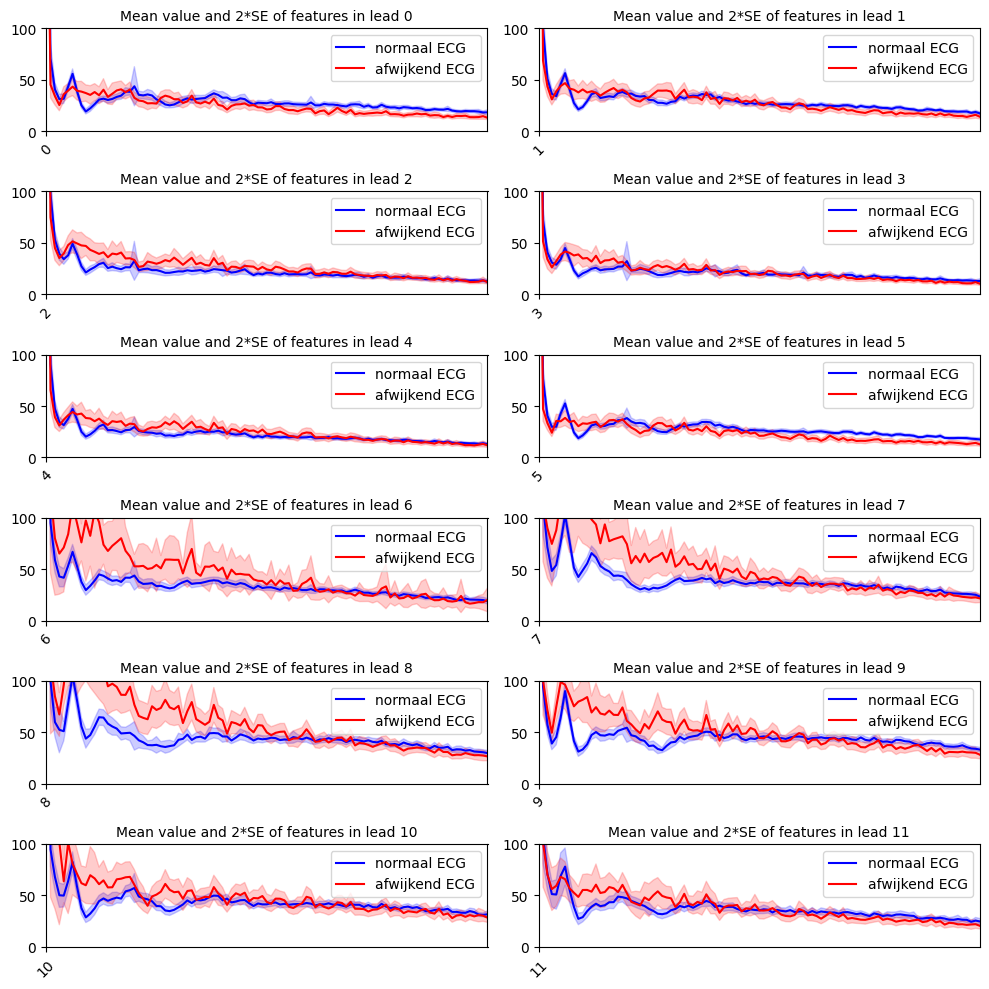

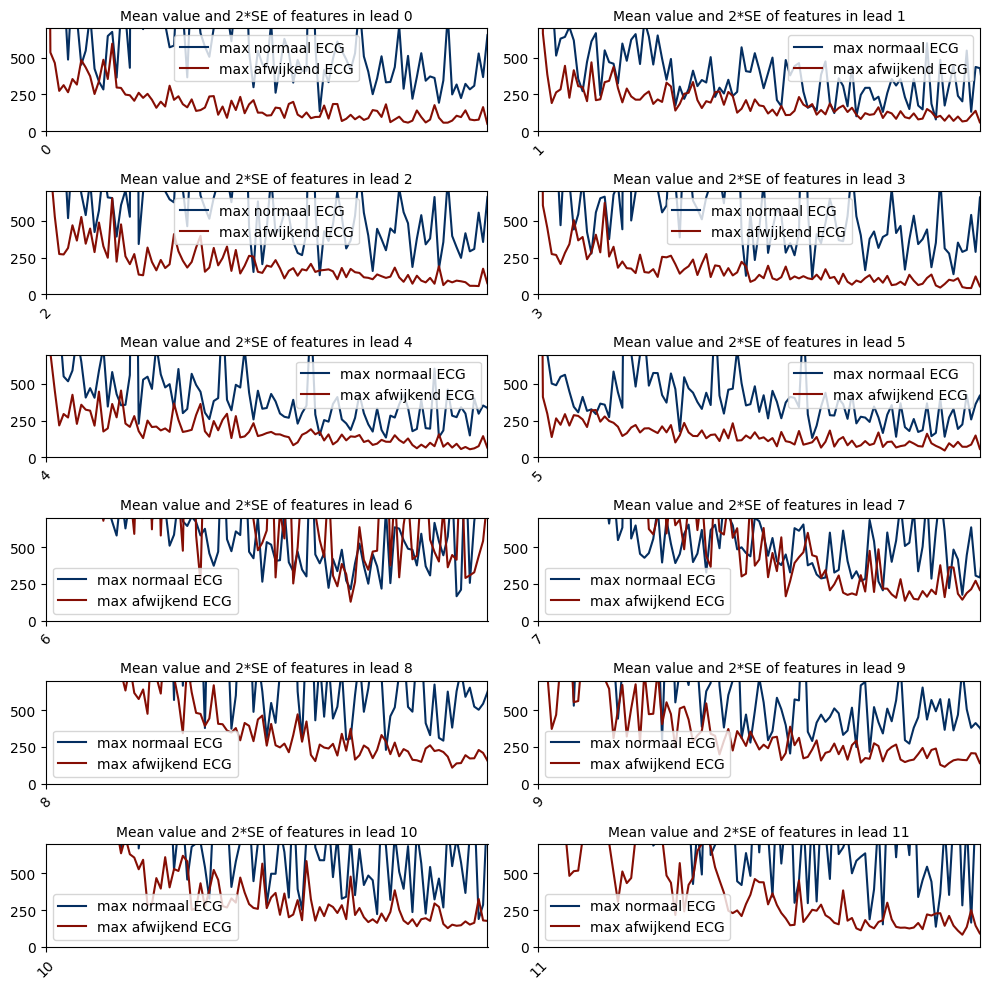

In [9]:
# looking at the first 100 features for a better visualization

plt.figure(figsize = [10,10])

number_leads = np.arange(0,12,1)

for number_lead in number_leads:
  ax = plt.subplot(6,2,number_lead+1)
  ax.plot(data.columns,data_mean_0,color = 'b')
  ax.plot(data.columns,data_mean_1,color = 'r')
  ax.fill_between(data.columns,lowerbound_0,upperbound_0,alpha = 0.2, color = 'b')
  ax.fill_between(data.columns,lowerbound_1,upperbound_1,alpha = 0.2, color = 'r')
  ax.set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
  ax.set_xlim(number_lead*750,(number_lead)*750+100)
  ax.set_ylim(0,100)
  ax.set_title(f'Mean value and 2*SE of features in lead {number_lead}',fontsize = 10)
  ax.legend(['normaal ECG','afwijkend ECG'])
plt.tight_layout()
plt.show()

plt.figure(figsize = [10,10])
for number_lead in number_leads:
  ax = plt.subplot(6,2,number_lead+1)
  ax.plot(data.columns,data_max_0,color = '#042e60')
  ax.plot(data.columns,data_max_1,color = '#850e04')
  ax.set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
  ax.set_xlim(number_lead*750,(number_lead)*750+100)
  ax.set_ylim(0,700)
  ax.set_title(f'Mean value and 2*SE of features in lead {number_lead}',fontsize = 10)
  ax.legend(['max normaal ECG','max afwijkend ECG'])
plt.tight_layout()
plt.show()


Based on these figures we can conclude that for some patients no ECG was recorded in certain leads. Although no features are present in these leads we choose to retain these samples as information other leads may be sufficient to make a classification.

However, users of this model should identify if leads are missing in the original data. An assumption of the input data in our model is that at least 11 of the 12 leads must be present.

In [10]:
print('Number of missing values:',data.isna().sum(1).sum())

Number of missing values: 0


There are no missing values present. An assumption of the input data in our model is that missing values should be handled in a appropriate manner depending on the frequency/distribution of the missing values.

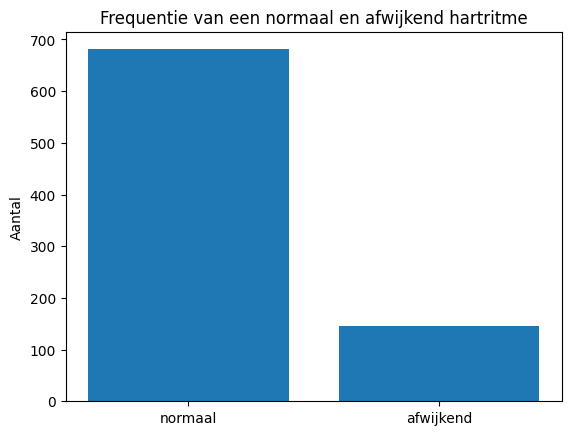

Ratio normal over abnormal ECG labels: 4.66


In [20]:
# Verhoudingen van de groepen
text = ['normaal','afwijkend']
labels = data['label']
lst_labels = list(labels)
frequentie = [lst_labels.count(0), lst_labels.count(1)]
plt.bar(text, frequentie)
plt.title('Frequentie van een normaal en afwijkend hartritme')
plt.ylabel('Aantal')
plt.show()

print(f'Ratio normal over abnormal ECG labels: {lst_labels.count(0)/lst_labels.count(1):.2f}')

The dataset is unbalanced: the number of normal ECG labels is almost 5 times larger than abnormal ECG labels.

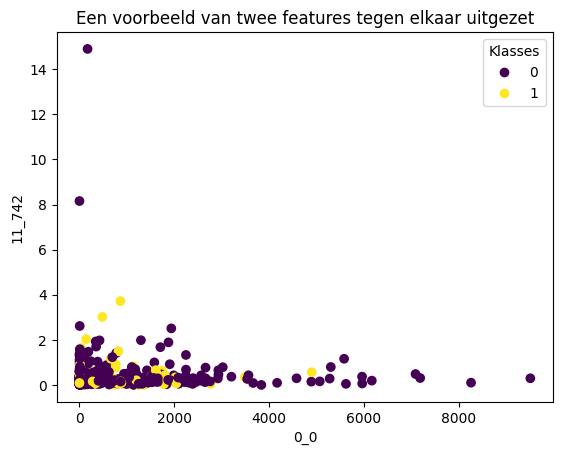

In [13]:
# Voorbeeld van een eerste plotje
import matplotlib.pyplot as plt

feature_1 = '0_0'
feature_2 = '11_742'
scatter = plt.scatter(data[feature_1],data[feature_2], c = labels)
plt.title('Een voorbeeld van twee features tegen elkaar uitgezet')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Klasses")
plt.show()

We can make a scatter of features. We observe that values have different magnitudes. Scaling is really important to relate the features.

In [14]:
# Testen per feature of het normaal verdeeld is per groep
from scipy.stats import shapiro

data_gezond = data[data["label"] == 0]
data_afwijkend = data[data["label"] == 1]

data_gezond = data_gezond.drop('label',axis = 1)
data_afwijkend = data_afwijkend.drop('label',axis = 1)

niet_nrml_vd_gezond = dict()
for kolomnaam in data_gezond.columns:
  statistiek = shapiro(list(data_gezond[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_gezond[kolomnaam] = statistiek[1]
print(niet_nrml_vd_gezond)

niet_nrml_vd_afwijkend = dict()
for kolomnaam in data_afwijkend.columns:
  statistiek = shapiro(list(data_afwijkend[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_afwijkend[kolomnaam] = statistiek[1]
print(niet_nrml_vd_afwijkend)



{}
{}


conclusie: Aan de hand van een shapiro test met een p-waarde van 0.05 is gebleken dat alle features normaal verdeeld zijn.

## Sorteren op meest significant verschillend
Hieronder wordt een tweezijdige T-test gedaan voor de data. Er wordt gekeken of er een significant verschil is tussen de gezond of ongezond groep per feature. De meest significant verschillende features worden vervolgens gebruikt om een pairplot te maken

In [22]:
from scipy.stats import ttest_ind
import numpy as np
p_values = ttest_ind(a=data_gezond, b=data_afwijkend, axis = 0, equal_var=False)

dict_p_values = dict()
for kolom in data_gezond.columns:
  p_value = ttest_ind(data_gezond[kolom],data_afwijkend[kolom],equal_var=False)
  dict_p_values[kolom] = p_value[1]

dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
print(dict_sorted_p_values)
features_sorted = list(dict_sorted_p_values.keys())
# sort_ind = np.argsort(p_values[1])
# print(sort_ind)
# print(np.array(p_values[1]))

{'5_64': 6.22352300920535e-11, '5_81': 6.728403620970126e-11, '0_64': 1.8669030342133047e-09, '0_90': 1.9540686755693923e-09, '0_81': 2.0379036849107236e-09, '0_101': 5.375006151792281e-09, '9_9': 5.662721265565916e-09, '0_70': 6.304111445729488e-09, '5_166': 1.3749854832042605e-08, '5_156': 2.0984850102660778e-08, '5_123': 2.512071172051967e-08, '8_9': 2.7910407544108588e-08, '5_138': 5.227908290281209e-08, '5_70': 6.202075219188155e-08, '5_41': 6.346763688391622e-08, '5_90': 1.165069308968035e-07, '5_147': 1.344182583545082e-07, '5_92': 1.629267908775338e-07, '5_120': 2.646812167584494e-07, '5_73': 2.8347130195845245e-07, '0_123': 3.048464710619129e-07, '2_9': 3.0965608633527446e-07, '0_41': 4.3093908559865693e-07, '5_101': 5.224020652619585e-07, '0_92': 5.580792580979418e-07, '0_102': 6.256240478016267e-07, '5_105': 6.478881564471267e-07, '3_9': 7.137292927242835e-07, '5_72': 8.087474286271428e-07, '5_78': 9.058009543867642e-07, '1_138': 9.463575315914679e-07, '0_108': 1.05457241346

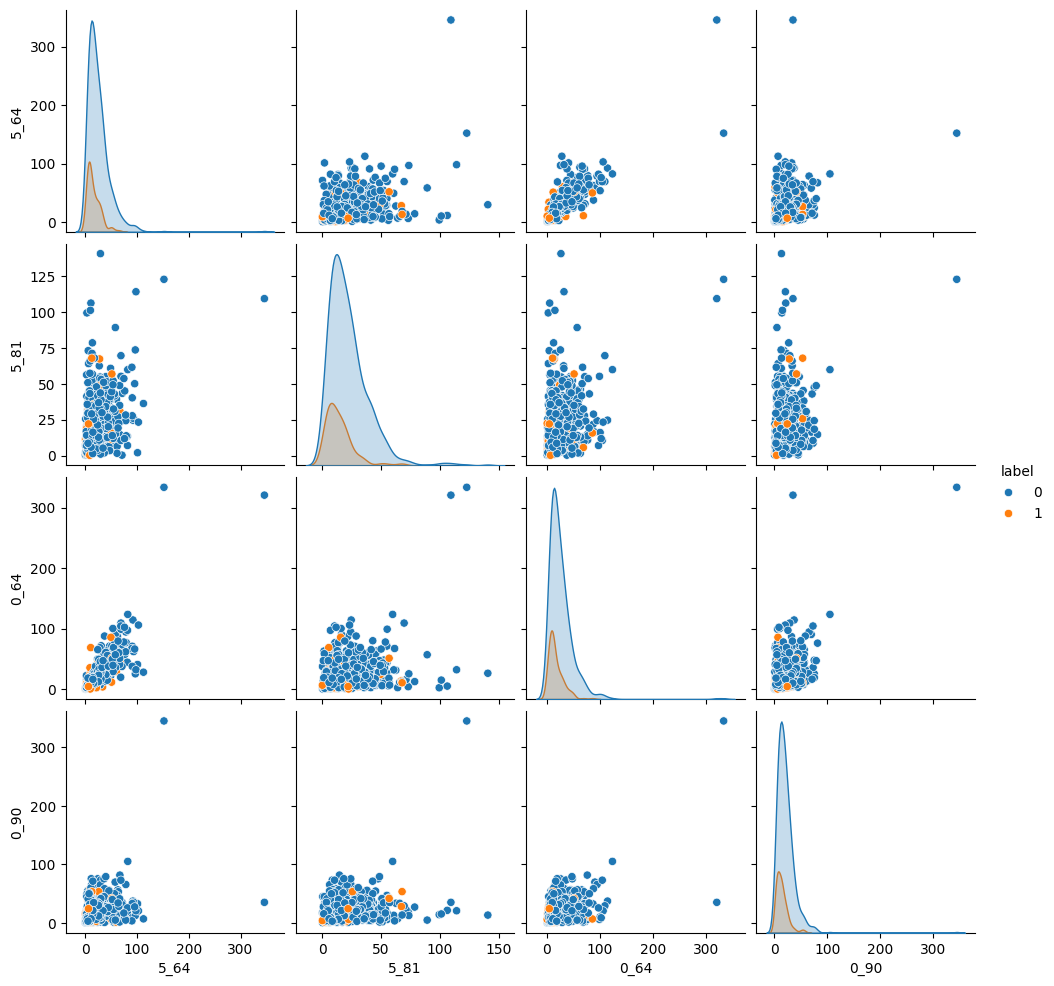

In [16]:
import seaborn as sns
most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")

Conclusion: normal and abnormal ECG labels the are not linearly separable in these features. We may need to use kernels to cover the non-linear behaviour of the data.